# Map Tweet to Census Region

This notebook maps tweets to the corresponding census regions

*Author: Koki Sasagawa*  
*Date: 4/14/2019*

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from shapely.geometry import Polygon, Point
from datetime import datetime
from pytz import timezone

sys.path.insert(0, '../utils/')
from twitter_processing import tweet_coordinate_mapper, tweet_aggregate_by_region, tweet_region_by_time_generator
from api import reverse_geocode
from decorators import timer

%matplotlib inline

In [2]:
# add timer 
tweet_coordinate_mapper = timer(tweet_coordinate_mapper)
tweet_region_by_time_generator = timer(tweet_region_by_time_generator)

## 1. Load Tweet data

1. Tweet data containing SF, or mention SF
2. Filtered tweets from each month that contain coordinates which map to greater area of San Fransisco

In [3]:
input_dir = '../../raw_data/tweets/'

files = sorted(os.listdir(input_dir))
for i, fname in enumerate(files):
    print(i, fname)

0 tweet_2016_02_01.csv
1 tweet_2016_02_02.csv
2 tweet_2016_02_03.csv
3 tweet_2016_02_04.csv
4 tweet_2016_02_05.csv
5 tweet_2016_02_06.csv
6 tweet_2016_02_07.csv
7 tweet_2016_02_08.csv
8 tweet_2016_02_09.csv
9 tweet_2016_02_10.csv
10 tweet_2016_02_11.csv
11 tweet_2016_02_12.csv
12 tweet_2016_02_13.csv
13 tweet_2016_02_14.csv
14 tweet_2016_02_15.csv
15 tweet_2016_02_16.csv
16 tweet_2016_02_17.csv
17 tweet_2016_02_18.csv
18 tweet_2016_02_19.csv
19 tweet_2016_02_20.csv
20 tweet_2016_02_21.csv
21 tweet_2016_02_22.csv
22 tweet_2016_02_23.csv
23 tweet_2016_02_24.csv
24 tweet_2016_02_25.csv
25 tweet_2016_02_26.csv
26 tweet_2016_02_27.csv
27 tweet_2016_02_28.csv
28 tweet_2016_02_29.csv


In [4]:
tweet1 = pd.read_csv(input_dir + files[0],
                     parse_dates=['time'],
                     # date_parser=dateparse,
                     infer_datetime_format=True)

print(files[0])
print("Dimensions: {}".format(tweet1.shape))
tweet1.head()

tweet_2016_02_01.csv
Dimensions: (3944, 13)


,lon,lat,time,time_stamp,text,hashtags,urls,user_mentions,favorite_count,retweet_count,user_followers_count,user_friends_count,user_statuses_count
0,-119.306608,37.269176,2016-02-01 05:00:15+00:00,1454302815740,"A guy at the airport:\n""Idk why he cut me off ...",0,0,0,0,0,160,189,1119
1,0.314300,42.308346,2016-02-01 05:01:01+00:00,1454302861683,"@JoptanElMagno @apranorte y lo mejor,no caer e...",0,0,2,0,0,302,727,14007
2,-122.435978,37.770657,2016-02-01 05:01:14+00:00,1454302874659,I rather him call me his friend then just a wh...,2,0,0,0,0,87,187,1362
3,-122.435978,37.770657,2016-02-01 05:01:39+00:00,1454302899722,https://t.co/WNKPn1itmN,0,0,0,0,0,10,47,1
4,-122.466364,37.780964,2016-02-01 05:01:50+00:00,1454302910678,attended @starparish Speaker Series: a gr8 pre...,0,1,1,0,0,751,748,16076


## 2. Match the timezone

The datetime used in the tweets are UTC.  
Convert these datetime objects to match San Francisco timezone (Pacific Standard Time) 

In [5]:
tweet1['time'].iloc[0]

Timestamp('2016-02-01 05:00:15+0000', tz='UTC')

In [6]:
def time_zone_converter(date, zone):
    """Convert the datetime object to a specified timezone
    
    :param date: datetime 
    :type date: pandas._libs.tslibs.timestamps.Timestamp
    :param str zone: desired timezone 
    :return: datetime in specified timezone 
    :rtype: pandas._libs.tslibs.timestamps.Timestamp
    """
    
    date_format = '%Y-%m-%d %H:%M:%S %Z'
    date.strftime(date_format)
    date = date.astimezone(timezone(zone))
    return date.strftime('%Y-%m-%d %H:%M:%S')

In [7]:
tweet1.loc[:, 'time'] = tweet1.apply(lambda row: time_zone_converter(date=row['time'], zone='US/Pacific'), axis=1)
tweet1.head()

,lon,lat,time,time_stamp,text,hashtags,urls,user_mentions,favorite_count,retweet_count,user_followers_count,user_friends_count,user_statuses_count
0,-119.306608,37.269176,2016-01-31 21:00:15,1454302815740,"A guy at the airport:\n""Idk why he cut me off ...",0,0,0,0,0,160,189,1119
1,0.314300,42.308346,2016-01-31 21:01:01,1454302861683,"@JoptanElMagno @apranorte y lo mejor,no caer e...",0,0,2,0,0,302,727,14007
2,-122.435978,37.770657,2016-01-31 21:01:14,1454302874659,I rather him call me his friend then just a wh...,2,0,0,0,0,87,187,1362
3,-122.435978,37.770657,2016-01-31 21:01:39,1454302899722,https://t.co/WNKPn1itmN,0,0,0,0,0,10,47,1
4,-122.466364,37.780964,2016-01-31 21:01:50,1454302910678,attended @starparish Speaker Series: a gr8 pre...,0,1,1,0,0,751,748,16076


There seems to be something off with the coordinates.
Check to see what address they map to

In [8]:
reverse_geocode(lon=-119.306608, lat=37.269176)

'Fresno, CA, United States'

In [9]:
reverse_geocode(lon=0.314300, lat=42.308346)

'La Fueva, Aragón, España'

In [10]:
reverse_geocode(lon=-122.435978, lat=37.770657)

'Lower Haight, San Francisco, CA, United States'

## 3. Convert lon, lat coordinates into GIS point

Configuring the coordinate_mapper function used to map speed data for twitter data. 

In [11]:
shp_file = '../../temp_data/sf_GEOID_GIS_data.shp'

# Load census data 
shp_file = gpd.GeoDataFrame.from_file(shp_file)
print('Size of census zones df: {}'.format(shp_file.shape))
shp_file.head()

Size of census zones df: (196, 2)


,geoid10,geometry
0,6075016500,"POLYGON ((-122.446471 37.775802, -122.44478 37..."
1,6075016400,"POLYGON ((-122.44034 37.77658, -122.439844 37...."
2,6075016300,"POLYGON ((-122.429152 37.778007, -122.428909 3..."
3,6075016100,"POLYGON ((-122.428909 37.778039, -122.429152 3..."
4,6075016000,"POLYGON ((-122.420425 37.780583, -122.420336 3..."


Remove the region ID 6075990100 from the shp file

In [12]:
shp_file = shp_file[shp_file["geoid10"] != 6075990100]
print(shp_file.shape)

(195, 2)


In [13]:
# Directory to store files created
output_dir = "../../temp_data/tweets_mapped/"

In [15]:
cols = np.delete(np.arange(13), 3)
cols

array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [16]:
# Test
test = tweet_coordinate_mapper(shp_file=shp_file,
                               input_dir=input_dir, 
                               output_dir=output_dir, 
                               file_name="tweet_2016_02_01.csv",
                               columns=cols,
                               col_time="time",
                               zone="US/Pacific")

test.head()

Running tweet_coordinate_mapper...
Mapping completed. Size before: 3944, Size after: 1458
Finished in 1.5306s


,lon,lat,time,text,hashtags,urls,user_mentions,favorite_count,retweet_count,user_followers_count,user_friends_count,user_statuses_count,geometry,index_right,geoid10
2,-122.435978,37.770657,2016-01-31 21:01:14,I rather him call me his friend then just a wh...,2,0,0,0,0,87,187,1362,POINT (-122.4359785 37.7706565),194,6075016700
3,-122.435978,37.770657,2016-01-31 21:01:39,https://t.co/WNKPn1itmN,0,0,0,0,0,10,47,1,POINT (-122.4359785 37.7706565),194,6075016700
7,-122.435978,37.770657,2016-01-31 21:03:44,Damn. Does Sandy love across the street from t...,1,0,0,0,0,887,956,29828,POINT (-122.4359785 37.7706565),194,6075016700
8,-122.435978,37.770657,2016-01-31 21:04:04,@angeles19820928 @AsiaPrince_JKS MIRA MI PERFI...,0,0,2,0,0,464,695,21266,POINT (-122.4359785 37.7706565),194,6075016700
9,-122.435978,37.770657,2016-01-31 21:04:10,"""We could butt chug two bottles of #wine, no p...",1,0,0,0,0,1218,2067,13010,POINT (-122.4359785 37.7706565),194,6075016700


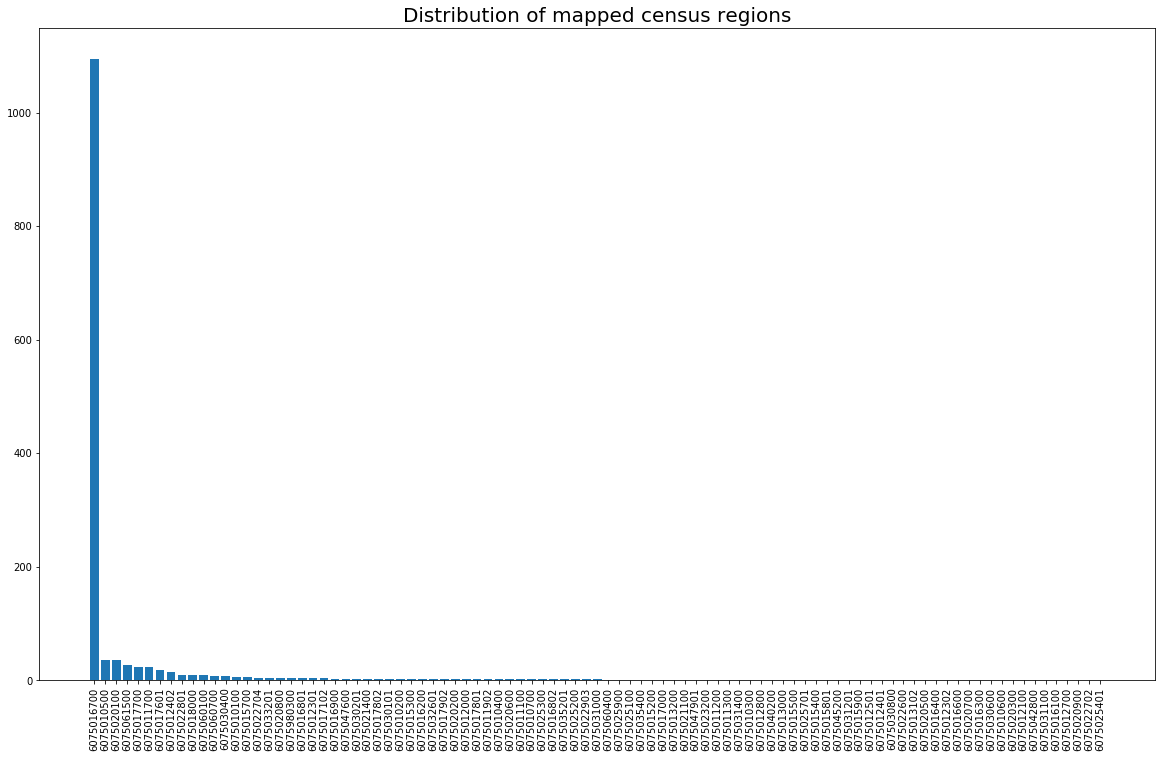

In [17]:
x = [str(x) for x in test['geoid10'].value_counts().index]
y = test['geoid10'].value_counts().values
plt.figure(1, figsize=(20,12))
plt.bar(x, y)
plt.title("Distribution of mapped census regions", fontsize=20)
plt.xticks(rotation=90)
plt.show()

The distribution of where tweets map by region in this test data is very skewed.  
Perhaps, this is due to using the coordinates associated with a place, which is obtained by taking the centroid.  
In other words, if many users identify a location as their geographical information (i.e., Union Squre),  
we take the centroid of this Polygon as the Point coordinate, which can result in multiple tweets sharing the exact same lon, lat coordinates. 

In [19]:
for fname in files:
    tweet_coordinate_mapper(shp_file=shp_file,
                               input_dir=input_dir, 
                               output_dir=output_dir, 
                               file_name=fname,
                               columns=cols,
                               col_time="time",
                               zone="US/Pacific")

Running tweet_coordinate_mapper...
Mapping completed. Size before: 3944, Size after: 1458
Finished in 1.4446s
Running tweet_coordinate_mapper...
Mapping completed. Size before: 4216, Size after: 1579
Finished in 1.6258s
Running tweet_coordinate_mapper...
Mapping completed. Size before: 3832, Size after: 1584
Finished in 1.4765s
Running tweet_coordinate_mapper...
Mapping completed. Size before: 4288, Size after: 1765
Finished in 1.6238s
Running tweet_coordinate_mapper...
Mapping completed. Size before: 3924, Size after: 1733
Finished in 1.4505s
Running tweet_coordinate_mapper...
Mapping completed. Size before: 4234, Size after: 1882
Finished in 1.6260s
Running tweet_coordinate_mapper...
Mapping completed. Size before: 5202, Size after: 2206
Finished in 1.8623s
Running tweet_coordinate_mapper...
Mapping completed. Size before: 3991, Size after: 1533
Finished in 1.5592s
Running tweet_coordinate_mapper...
Mapping completed. Size before: 3605, Size after: 1380
Finished in 1.3184s
Running tw

## 4. Aggregate by census region

In [20]:
input_dir = '../../temp_data/tweets_mapped/'
output_dir = '../../temp_data/region_tweets/'

In [21]:
tweet_aggregate_by_region(input_dir, output_dir, base_fname='tweet_time_series_region')

Finished partitioning mapped_tweet_2016_02_01.csv
Finished partitioning mapped_tweet_2016_02_02.csv
Finished partitioning mapped_tweet_2016_02_03.csv
Finished partitioning mapped_tweet_2016_02_04.csv
Finished partitioning mapped_tweet_2016_02_05.csv
Finished partitioning mapped_tweet_2016_02_06.csv
Finished partitioning mapped_tweet_2016_02_07.csv
Finished partitioning mapped_tweet_2016_02_08.csv
Finished partitioning mapped_tweet_2016_02_09.csv
Finished partitioning mapped_tweet_2016_02_10.csv
Finished partitioning mapped_tweet_2016_02_11.csv
Finished partitioning mapped_tweet_2016_02_12.csv
Finished partitioning mapped_tweet_2016_02_13.csv
Finished partitioning mapped_tweet_2016_02_14.csv
Finished partitioning mapped_tweet_2016_02_15.csv
Finished partitioning mapped_tweet_2016_02_16.csv
Finished partitioning mapped_tweet_2016_02_17.csv
Finished partitioning mapped_tweet_2016_02_18.csv
Finished partitioning mapped_tweet_2016_02_19.csv
Finished partitioning mapped_tweet_2016_02_20.csv


## Tweet features by region 
Features: 
1. text
2. hashtagurls
3. user_mentions
4. favorite_count
5. retweet_count
6. user_followers_count
7. user_friends_count
8. user_statuses_count

### Tweet counts

In [24]:
tweet_count = tweet_region_by_time_generator(output_dir, columns=['time'], Y='text', usecols=[2,3,4,5,6,7,8,9,10,11])
print("Dimensions: {}".format(tweet_count.shape))
tweet_count.head()

Running tweet_region_by_time_generator...
Reading files from directory: ../../temp_data/region_tweets/
Finished in 1.7958s
Dimensions: (188, 696)


time,2016-01-31 21:00:00,2016-01-31 22:00:00,2016-01-31 23:00:00,2016-02-01 00:00:00,2016-02-01 01:00:00,2016-02-01 02:00:00,2016-02-01 03:00:00,2016-02-01 04:00:00,2016-02-01 05:00:00,2016-02-01 06:00:00,...,2016-02-29 11:00:00,2016-02-29 12:00:00,2016-02-29 13:00:00,2016-02-29 14:00:00,2016-02-29 15:00:00,2016-02-29 16:00:00,2016-02-29 17:00:00,2016-02-29 18:00:00,2016-02-29 19:00:00,2016-02-29 20:00:00
tweet_region_6075010100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN
tweet_region_6075010200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tweet_region_6075010300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
tweet_region_6075010400,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tweet_region_6075010500,1.0,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN


Due to the tweets being in UTC, the timezone conversion resulted in shifting values. We therefore, do not have the last 3 hours of Feb 29th (9pm - 12AM) 
* Drop the first 3 columns (Janurary)

In [25]:
# Total number of cells
total = np.prod(tweet_count.shape)
# Get number of missing cells
missing = sum(tweet_count.isna().sum().values)
print("Total nan cells: {} out of {} or {:.2f}%".format(missing, total, (missing / total) * 100))

Total nan cells: 121993 out of 130848 or 93.23%


As expected, the tweets are very sparse due to filtering and mapping. 
Consider taking the total sum of by column to have a measure of activity per hour

In [26]:
tweet_count_by_hour = pd.DataFrame(tweet_count.sum(axis=0)).transpose()
tweet_count_by_hour
# tweet_counts_by_hour

time,2016-01-31 21:00:00,2016-01-31 22:00:00,2016-01-31 23:00:00,2016-02-01 00:00:00,2016-02-01 01:00:00,2016-02-01 02:00:00,2016-02-01 03:00:00,2016-02-01 04:00:00,2016-02-01 05:00:00,2016-02-01 06:00:00,...,2016-02-29 11:00:00,2016-02-29 12:00:00,2016-02-29 13:00:00,2016-02-29 14:00:00,2016-02-29 15:00:00,2016-02-29 16:00:00,2016-02-29 17:00:00,2016-02-29 18:00:00,2016-02-29 19:00:00,2016-02-29 20:00:00
0,10.0,10.0,11.0,4.0,3.0,4.0,4.0,1.0,7.0,4.0,...,21.0,18.0,14.0,18.0,21.0,17.0,14.0,6.0,13.0,19.0


In [27]:
tweet_count_by_hour.columns[0]

Timestamp('2016-01-31 21:00:00', freq='H')

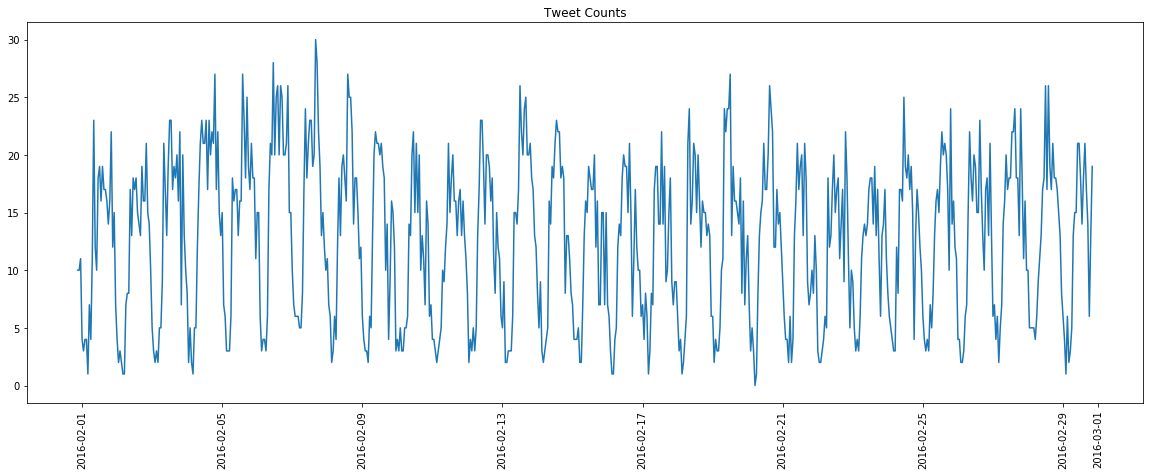

In [29]:
plt.figure(1, figsize=(20,7))
plt.plot(tweet_count_by_hour.columns, tweet_count_by_hour.iloc[0].values)
plt.title("Tweet Counts")
plt.xticks(rotation=90)
plt.show()

### Hashtag count

In [30]:
hashtag_count = tweet_region_by_time_generator(output_dir, columns=['time'], Y='hashtags', usecols=[2,3,4,5,6,7,8,9,10])
hashtag_count_by_hour = pd.DataFrame(hashtag_count.sum(axis=0)).transpose()
hashtag_count_by_hour

Running tweet_region_by_time_generator...
Reading files from directory: ../../temp_data/region_tweets/
Finished in 1.7408s


time,2016-01-31 21:00:00,2016-01-31 22:00:00,2016-01-31 23:00:00,2016-02-01 00:00:00,2016-02-01 01:00:00,2016-02-01 02:00:00,2016-02-01 03:00:00,2016-02-01 04:00:00,2016-02-01 05:00:00,2016-02-01 06:00:00,...,2016-02-29 11:00:00,2016-02-29 12:00:00,2016-02-29 13:00:00,2016-02-29 14:00:00,2016-02-29 15:00:00,2016-02-29 16:00:00,2016-02-29 17:00:00,2016-02-29 18:00:00,2016-02-29 19:00:00,2016-02-29 20:00:00
0,5.333333,7.258621,17.108108,5.121212,2.3125,8.0,7.0,0.0,5.1,15.294118,...,20.685897,25.866667,17.090909,24.553333,15.955932,19.730769,20.693878,7.114286,12.155556,15.439394


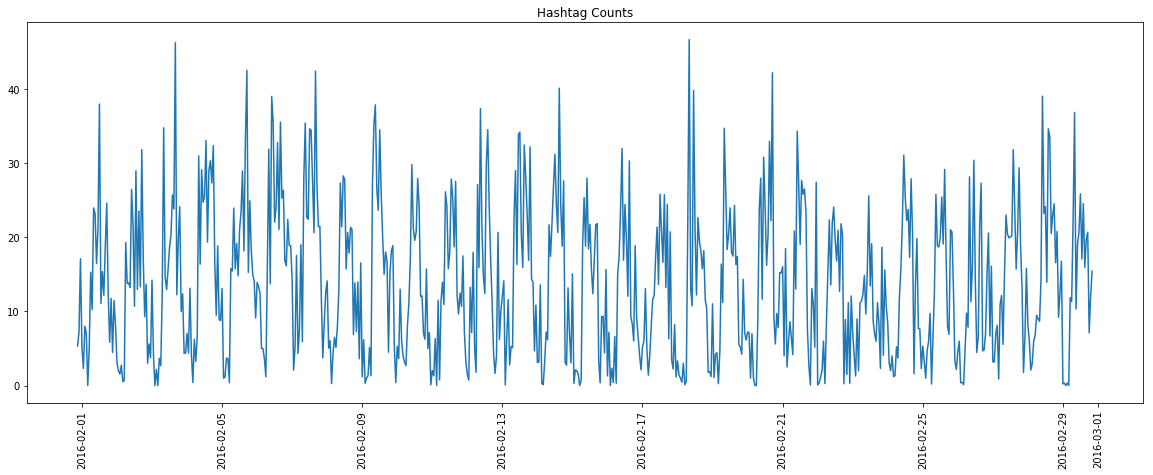

In [31]:
plt.figure(2, figsize=(20,7))
plt.plot(hashtag_count_by_hour.columns, hashtag_count_by_hour.iloc[0].values)
plt.title("Hashtag Counts")
plt.xticks(rotation=90)
plt.show()

### urls

In [32]:
url_count = tweet_region_by_time_generator(output_dir, columns=['time'], Y='urls', usecols=[2,3,4,5,6,7,8,9,10])
url_count_by_hour = pd.DataFrame(url_count.sum(axis=0)).transpose()
url_count_by_hour

Running tweet_region_by_time_generator...
Reading files from directory: ../../temp_data/region_tweets/
Finished in 1.6060s


time,2016-01-31 21:00:00,2016-01-31 22:00:00,2016-01-31 23:00:00,2016-02-01 00:00:00,2016-02-01 01:00:00,2016-02-01 02:00:00,2016-02-01 03:00:00,2016-02-01 04:00:00,2016-02-01 05:00:00,2016-02-01 06:00:00,...,2016-02-29 11:00:00,2016-02-29 12:00:00,2016-02-29 13:00:00,2016-02-29 14:00:00,2016-02-29 15:00:00,2016-02-29 16:00:00,2016-02-29 17:00:00,2016-02-29 18:00:00,2016-02-29 19:00:00,2016-02-29 20:00:00
0,6.121212,7.12069,7.216216,3.090909,2.25,2.125,3.0,0.666667,5.2,3.117647,...,15.730769,11.5,9.363636,11.14,16.635593,13.230769,11.22449,5.085714,8.155556,12.94697


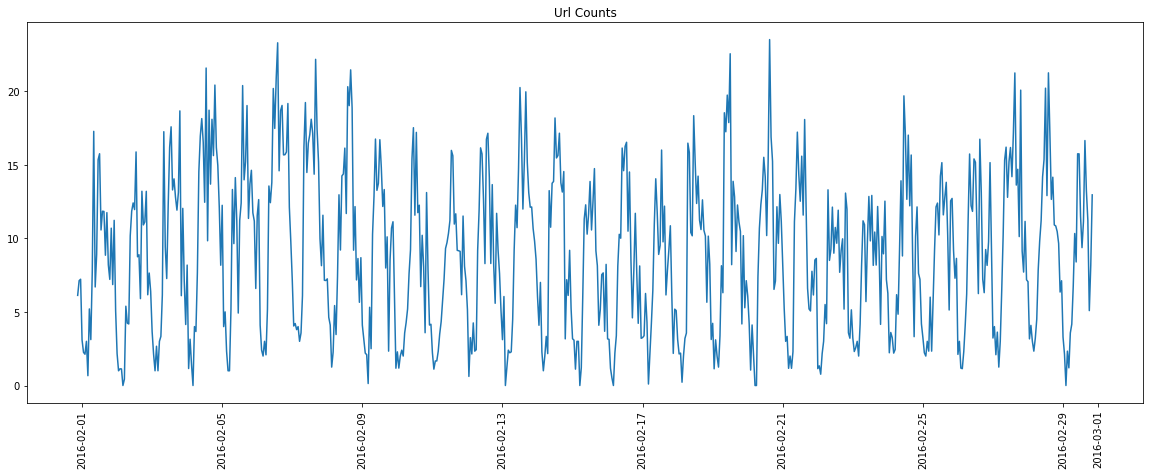

In [33]:
plt.figure(3, figsize=(20,7))
plt.plot(url_count_by_hour.columns, url_count_by_hour.iloc[0].values)
plt.title("Url Counts")
plt.xticks(rotation=90)
plt.show()

### user_mentions

In [34]:
user_mentions_count = tweet_region_by_time_generator(output_dir, columns=['time'], Y='user_mentions', usecols=[2,3,4,5,6,7,8,9,10])
user_mentions_count_by_hour = pd.DataFrame(user_mentions_count.sum(axis=0)).transpose()
user_mentions_count_by_hour

Running tweet_region_by_time_generator...
Reading files from directory: ../../temp_data/region_tweets/
Finished in 1.6060s


time,2016-01-31 21:00:00,2016-01-31 22:00:00,2016-01-31 23:00:00,2016-02-01 00:00:00,2016-02-01 01:00:00,2016-02-01 02:00:00,2016-02-01 03:00:00,2016-02-01 04:00:00,2016-02-01 05:00:00,2016-02-01 06:00:00,...,2016-02-29 11:00:00,2016-02-29 12:00:00,2016-02-29 13:00:00,2016-02-29 14:00:00,2016-02-29 15:00:00,2016-02-29 16:00:00,2016-02-29 17:00:00,2016-02-29 18:00:00,2016-02-29 19:00:00,2016-02-29 20:00:00
0,5.69697,5.724138,2.486486,0.393939,0.5,0.25,2.0,0.333333,1.4,0.941176,...,6.153846,10.716667,6.378788,7.383333,4.561582,4.403846,4.377551,0.714286,0.6,10.621212


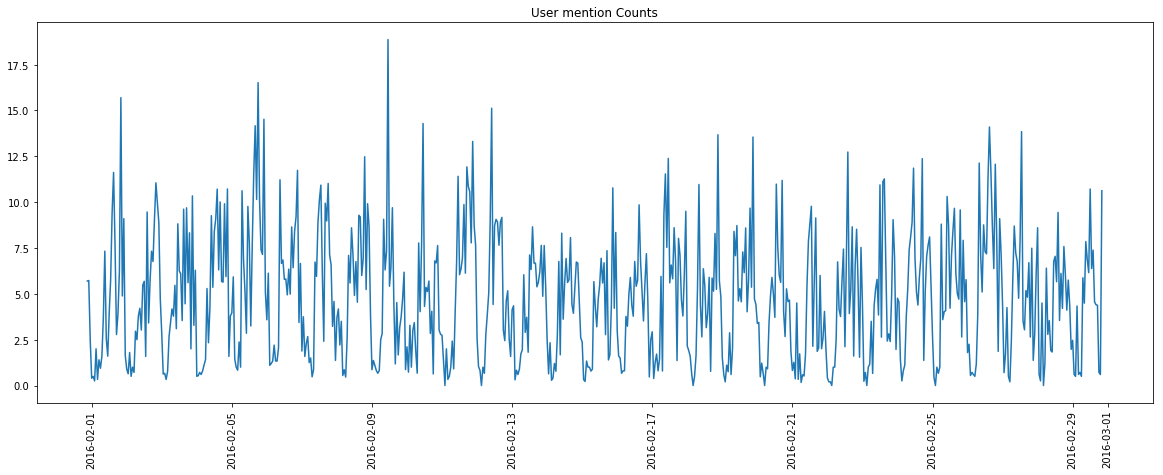

In [35]:
plt.figure(4, figsize=(20,7))
plt.plot(user_mentions_count_by_hour.columns, user_mentions_count_by_hour.iloc[0].values)
plt.title("User mention Counts")
plt.xticks(rotation=90)
plt.show()

### favorite_count

In [36]:
favorite_count = tweet_region_by_time_generator(output_dir, columns=['time'], Y='favorite_count', usecols=[2,3,4,5,6,7,8,9,10])
favorite_count_by_hour = pd.DataFrame(favorite_count.sum(axis=0)).transpose()
favorite_count_by_hour

Running tweet_region_by_time_generator...
Reading files from directory: ../../temp_data/region_tweets/
Finished in 1.6682s


time,2016-01-31 21:00:00,2016-01-31 22:00:00,2016-01-31 23:00:00,2016-02-01 00:00:00,2016-02-01 01:00:00,2016-02-01 02:00:00,2016-02-01 03:00:00,2016-02-01 04:00:00,2016-02-01 05:00:00,2016-02-01 06:00:00,...,2016-02-29 11:00:00,2016-02-29 12:00:00,2016-02-29 13:00:00,2016-02-29 14:00:00,2016-02-29 15:00:00,2016-02-29 16:00:00,2016-02-29 17:00:00,2016-02-29 18:00:00,2016-02-29 19:00:00,2016-02-29 20:00:00
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


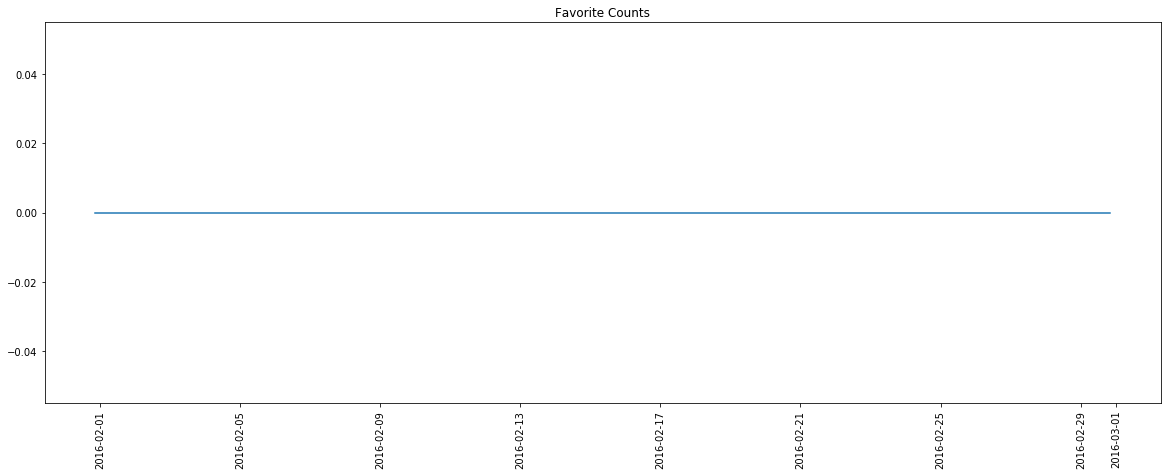

In [37]:
plt.figure(4, figsize=(20,7))
plt.plot(favorite_count_by_hour.columns, favorite_count_by_hour.iloc[0].values)
plt.title("Favorite Counts")
plt.xticks(rotation=90)
plt.show()

### retweet_count

In [38]:
retweet_count = tweet_region_by_time_generator(output_dir, columns=['time'], Y='retweet_count', usecols=[2,3,4,5,6,7,8,9,10])
retweet_count_by_hour = pd.DataFrame(retweet_count.sum(axis=0)).transpose()
retweet_count_by_hour

Running tweet_region_by_time_generator...
Reading files from directory: ../../temp_data/region_tweets/
Finished in 1.8407s


time,2016-01-31 21:00:00,2016-01-31 22:00:00,2016-01-31 23:00:00,2016-02-01 00:00:00,2016-02-01 01:00:00,2016-02-01 02:00:00,2016-02-01 03:00:00,2016-02-01 04:00:00,2016-02-01 05:00:00,2016-02-01 06:00:00,...,2016-02-29 11:00:00,2016-02-29 12:00:00,2016-02-29 13:00:00,2016-02-29 14:00:00,2016-02-29 15:00:00,2016-02-29 16:00:00,2016-02-29 17:00:00,2016-02-29 18:00:00,2016-02-29 19:00:00,2016-02-29 20:00:00
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


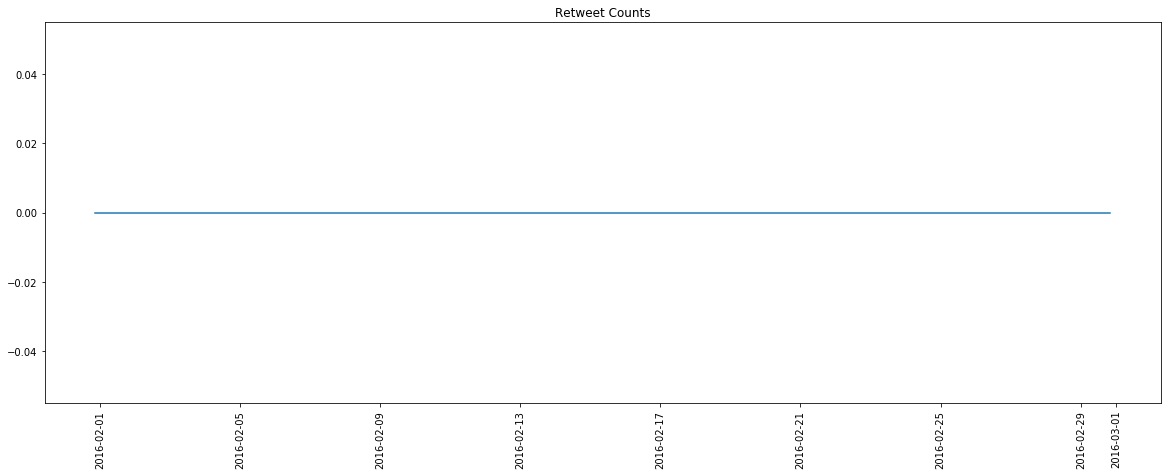

In [39]:
plt.figure(5, figsize=(20,7))
plt.plot(retweet_count_by_hour.columns, retweet_count_by_hour.iloc[0].values)
plt.title("Retweet Counts")
plt.xticks(rotation=90)
plt.show()

### User follower count 

In [40]:
follower_count = tweet_region_by_time_generator(output_dir, columns=['time'], Y='user_followers_count', usecols=[2,3,4,5,6,7,8,9,10])
follower_count_by_hour = pd.DataFrame(follower_count.sum(axis=0)).transpose()
follower_count_by_hour

Running tweet_region_by_time_generator...
Reading files from directory: ../../temp_data/region_tweets/
Finished in 1.8136s


time,2016-01-31 21:00:00,2016-01-31 22:00:00,2016-01-31 23:00:00,2016-02-01 00:00:00,2016-02-01 01:00:00,2016-02-01 02:00:00,2016-02-01 03:00:00,2016-02-01 04:00:00,2016-02-01 05:00:00,2016-02-01 06:00:00,...,2016-02-29 11:00:00,2016-02-29 12:00:00,2016-02-29 13:00:00,2016-02-29 14:00:00,2016-02-29 15:00:00,2016-02-29 16:00:00,2016-02-29 17:00:00,2016-02-29 18:00:00,2016-02-29 19:00:00,2016-02-29 20:00:00
0,22403.621212,13061.224138,58042.310811,9306.787879,1938.75,3530.625,1617.5,900.666667,16315.8,3819.764706,...,48994.448718,61258.133333,45293.090909,51073.533333,15250.418079,111347.903846,47295.311224,12251.628571,8009.111111,81925.409091


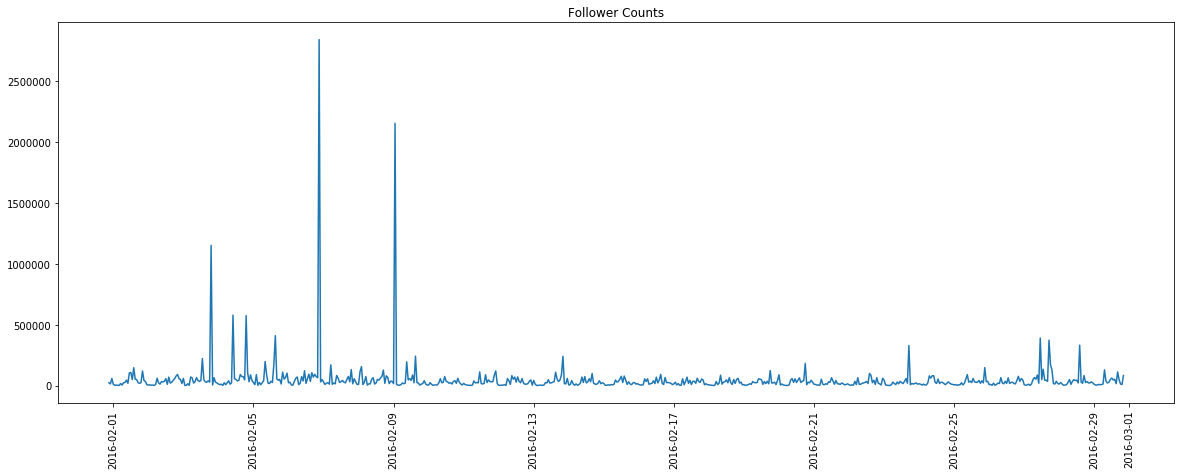

In [41]:
plt.figure(6, figsize=(20,7))
plt.plot(follower_count_by_hour.columns, follower_count_by_hour.iloc[0].values)
plt.title("Follower Counts")
plt.xticks(rotation=90)
plt.show()

### Friends count

In [42]:
friends_count = tweet_region_by_time_generator(output_dir, columns=['time'], Y='user_friends_count', usecols=[2,3,4,5,6,7,8,9,10])
friends_count_by_hour = pd.DataFrame(friends_count.sum(axis=0)).transpose()
friends_count_by_hour

Running tweet_region_by_time_generator...
Reading files from directory: ../../temp_data/region_tweets/
Finished in 1.5928s


time,2016-01-31 21:00:00,2016-01-31 22:00:00,2016-01-31 23:00:00,2016-02-01 00:00:00,2016-02-01 01:00:00,2016-02-01 02:00:00,2016-02-01 03:00:00,2016-02-01 04:00:00,2016-02-01 05:00:00,2016-02-01 06:00:00,...,2016-02-29 11:00:00,2016-02-29 12:00:00,2016-02-29 13:00:00,2016-02-29 14:00:00,2016-02-29 15:00:00,2016-02-29 16:00:00,2016-02-29 17:00:00,2016-02-29 18:00:00,2016-02-29 19:00:00,2016-02-29 20:00:00
0,6789.5,5037.810345,4376.621622,4422.333333,1651.125,1420.125,608.0,647.0,11038.9,1587.941176,...,14280.570513,10854.966667,8275.136364,10609.486667,8118.302825,9181.596154,15655.836735,7676.714286,5569.466667,16116.257576


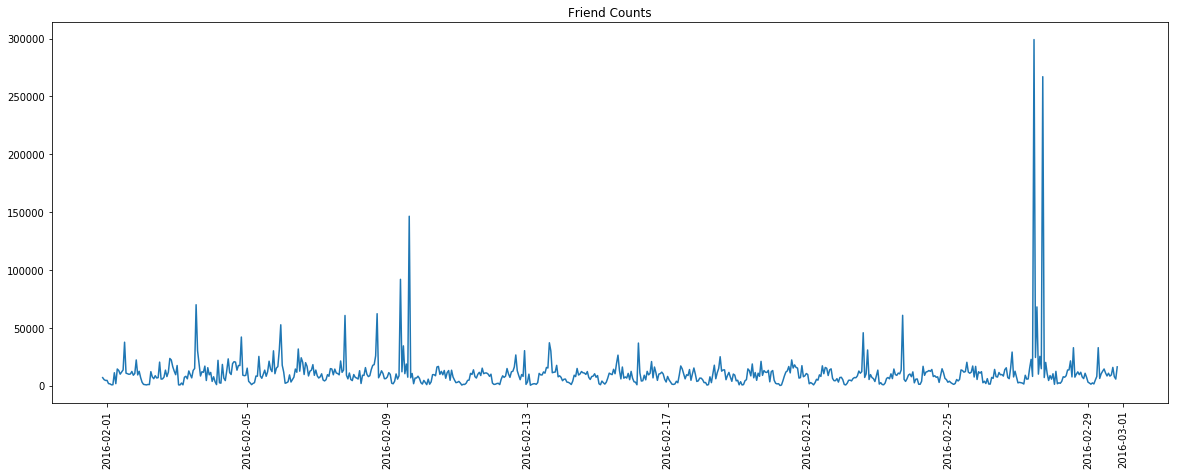

In [43]:
plt.figure(7, figsize=(20,7))
plt.plot(friends_count_by_hour.columns, friends_count_by_hour.iloc[0].values)
plt.title("Friend Counts")
plt.xticks(rotation=90)
plt.show()

In [45]:
status_count = tweet_region_by_time_generator(output_dir, columns=['time'], Y='user_statuses_count', usecols=[2,3,4,5,6,7,8,9,10,11])
status_count_by_hour = pd.DataFrame(status_count.sum(axis=0)).transpose()
status_count_by_hour

Running tweet_region_by_time_generator...
Reading files from directory: ../../temp_data/region_tweets/
Finished in 1.6567s


time,2016-01-31 21:00:00,2016-01-31 22:00:00,2016-01-31 23:00:00,2016-02-01 00:00:00,2016-02-01 01:00:00,2016-02-01 02:00:00,2016-02-01 03:00:00,2016-02-01 04:00:00,2016-02-01 05:00:00,2016-02-01 06:00:00,...,2016-02-29 11:00:00,2016-02-29 12:00:00,2016-02-29 13:00:00,2016-02-29 14:00:00,2016-02-29 15:00:00,2016-02-29 16:00:00,2016-02-29 17:00:00,2016-02-29 18:00:00,2016-02-29 19:00:00,2016-02-29 20:00:00
0,235238.030303,166488.637931,552116.135135,46131.060606,21593.0625,81491.375,92964.0,58675.0,716291.9,47789.235294,...,1.040294e+06,787322.2,523303.378788,875767.493333,2.633007e+06,1229954.0,1.434534e+06,374095.771429,221990.233333,708750.666667


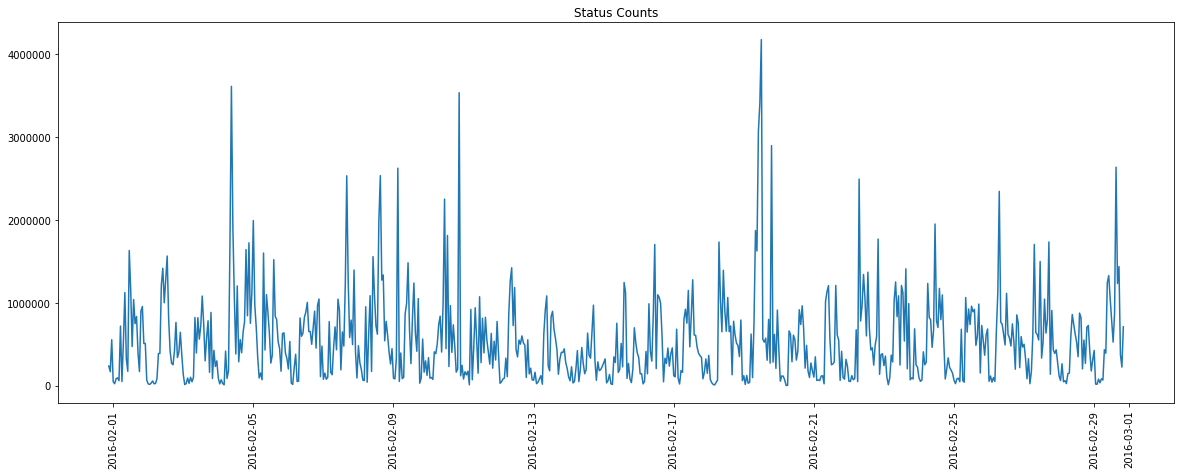

In [46]:
plt.figure(7, figsize=(20,7))
plt.plot(status_count_by_hour.columns, status_count_by_hour.iloc[0].values)
plt.title("Status Counts")
plt.xticks(rotation=90)
plt.show()

## All data

In [47]:
all_data_by_hour = pd.concat([tweet_count_by_hour,
                              url_count_by_hour, 
                              hashtag_count_by_hour, 
                              user_mentions_count_by_hour, 
                              follower_count_by_hour,
                              status_count_by_hour])

all_data_by_hour.index = ['tweet_count', 'url_count', 'hashtag_count', 'user_mentions_count', 'follower_count', 'status_count']
print("Dimensions: {}".format(all_data_by_hour.shape))
all_data_by_hour.head(10)

Dimensions: (6, 696)


time,2016-01-31 21:00:00,2016-01-31 22:00:00,2016-01-31 23:00:00,2016-02-01 00:00:00,2016-02-01 01:00:00,2016-02-01 02:00:00,2016-02-01 03:00:00,2016-02-01 04:00:00,2016-02-01 05:00:00,2016-02-01 06:00:00,...,2016-02-29 11:00:00,2016-02-29 12:00:00,2016-02-29 13:00:00,2016-02-29 14:00:00,2016-02-29 15:00:00,2016-02-29 16:00:00,2016-02-29 17:00:00,2016-02-29 18:00:00,2016-02-29 19:00:00,2016-02-29 20:00:00
tweet_count,10.000000,10.000000,11.000000,4.000000,3.0000,4.000,4.0,1.000000,7.0,4.000000,...,21.000000,18.000000,14.000000,18.000000,21.000000,17.000000,14.000000,6.000000,13.000000,19.000000
url_count,6.121212,7.120690,7.216216,3.090909,2.2500,2.125,3.0,0.666667,5.2,3.117647,...,15.730769,11.500000,9.363636,11.140000,16.635593,13.230769,11.224490,5.085714,8.155556,12.946970
hashtag_count,5.333333,7.258621,17.108108,5.121212,2.3125,8.000,7.0,0.000000,5.1,15.294118,...,20.685897,25.866667,17.090909,24.553333,15.955932,19.730769,20.693878,7.114286,12.155556,15.439394
user_mentions_count,5.696970,5.724138,2.486486,0.393939,0.5000,0.250,2.0,0.333333,1.4,0.941176,...,6.153846,10.716667,6.378788,7.383333,4.561582,4.403846,4.377551,0.714286,0.600000,10.621212
follower_count,22403.621212,13061.224138,58042.310811,9306.787879,1938.7500,3530.625,1617.5,900.666667,16315.8,3819.764706,...,48994.448718,61258.133333,45293.090909,51073.533333,15250.418079,111347.903846,47295.311224,12251.628571,8009.111111,81925.409091


In [48]:
all_data_by_hour.to_csv('../../output/tweet_features_by_hour.csv')